# TESS follow-up : Ecllipsing binary

In this tutorial we will see how to use prose to reduce data from a TESS transit follow-up and check for near eclipsing binary (NEB) signal in the TESS aperture.

The TESS candidate we want to follow-up has the following parameters

In [1]:
# TOI 2084.02
TIC = 441738827

# Candidate transit
epoch = 2458745.410754
period = 8.149028
duration = 2.321055/24
depth = 3.099506e-3

It has been observed with [Artemis](https://www.speculoos.uliege.be/cms/c_4549211/en/speculoos-north-sno), a 1-meter telescope based in the [Teide observatory](https://www.iac.es/en/observatorios-de-canarias/teide-observatory) (Canarias, Spain).

Since the reduction process is described in the [reduction tutorial](../reduction/reduction.ipynb) we will cover it quickly and focus on the NEB diagnostic instead.

## Reduction

Starting from our raw data, the reduction process is simply:

```python
from prose import FitsManager, Reduction, AperturePhotometry

# Loading files
fm = FitsManager(fits_folder, depth=2)
fm.describe("calib")

# Reduction
reduction = Reduction(fm)
reduction.run()

#Photometry
photometry = AperturePhotometry(reduction.destination)
photometry.run()
```

## Differential photometry

Now that we have a ``phot`` file to work with (*download here soon - TODO*) we can build up the differential light curves of stars in the field. Let's load our dataset and have a look at the field

<div class="alert alert-info">
Note

Provided ``phot`` actually contains a lighter version of the real observation with less aperture to reduce file size (Typical size is ~120Mb)
</div>


In [2]:
from prose import load, viz
import matplotlib.pyplot as plt

obs = load("/Users/lionelgarcia/Downloads/Artemis_20200817_TOI-2084-01_I+z_light.phot")

Let's show our field. Since our target is in the Tess Input Catalog (TIC) we can also overplot TIC-ids in the field

<Figure size 432x288 with 0 Axes>

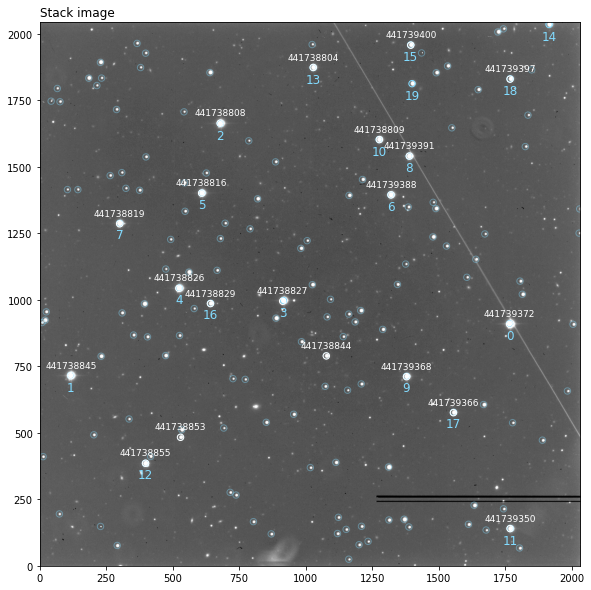

In [12]:
# Our target is proabably in the 20 brightest detected stars
obs.show_stars(size=10, view="all", n=20)
obs.show_tic(n=20) 

Our target is definetely the ``3``. We can set it and produce its differential flux (using the Broeg 2006 algorithm)

Text(0, 0.5, 'diff. flux')

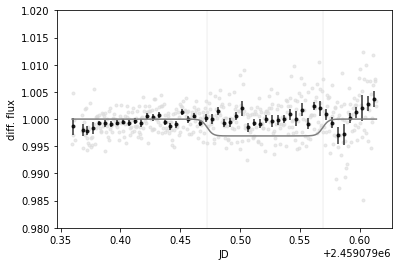

In [13]:
obs.target = 3

df = obs.broeg2005()
df.plot()

# We can plot the expected transit here
viz.plot_expected_transit(obs.time, epoch, period, duration, depth)

plt.ylim(0.98, 1.02)
plt.xlabel("JD")
plt.ylabel("diff. flux")

## NEB check

Presence of the transit is, at first sight, not very convincing. We are going to import the `~prose.diagnostics.NEB`{.interpreted-text role="class"} tool and instantiate it on our observation

<Figure size 432x288 with 0 Axes>

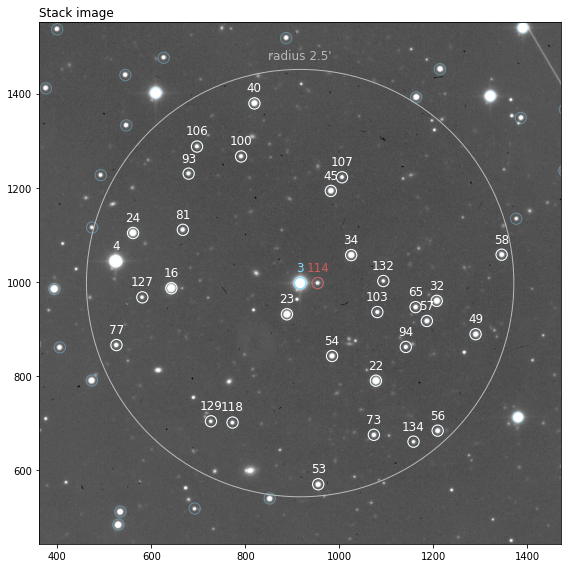

In [14]:
from prose.diagnostics import NEB
from prose.builtins import TESS_pixel

neb = NEB(df, radius=TESS_pixel)
neb.transit = dict(epoch=epoch, duration=duration, depth=depth, period=period)

_ = neb.show_stars(size=8)

It seems that a star exhibit a potential matching signals. Let's plot it

Text(9.0, 0.5, 'diff. flux')

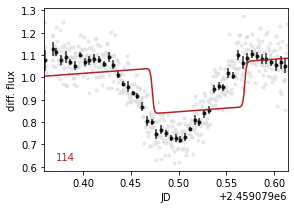

In [15]:
neb.plot_suspects()

plt.xlabel("JD")
plt.ylabel("diff. flux")

Star ``114`` looks like a good suspect. We can rebuild the light-curve for this target to be sure

Text(0, 0.5, 'diff. flux')

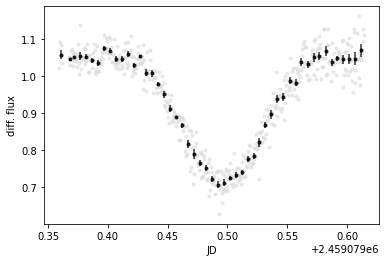

In [16]:
obs.target = 114
df_114 = obs.broeg2005()
df_114.plot()

plt.xlabel("JD")
plt.ylabel("diff. flux")

Now more rigourous analysis can be done to model this signal and indeed show that it may be at the origin of a false positive.

To have a thorough view of all light curve in the field and there potential contribution in the searched signal, you can export a pdf report from the NEB diagnostic with:

In [8]:
neb.save_report(f"./{obs.telescope.name}_{obs.date}_{obs.name}_{obs.filter}_NEB_report.pdf")

# Let's also save our analysis
df.save()

report saved at ./Artemis_20200817_TOI-2084-01_I+z_NEB_report.pdf


<Figure size 432x288 with 0 Axes>

<Figure size 720x252 with 0 Axes>

or even go with a complete plot

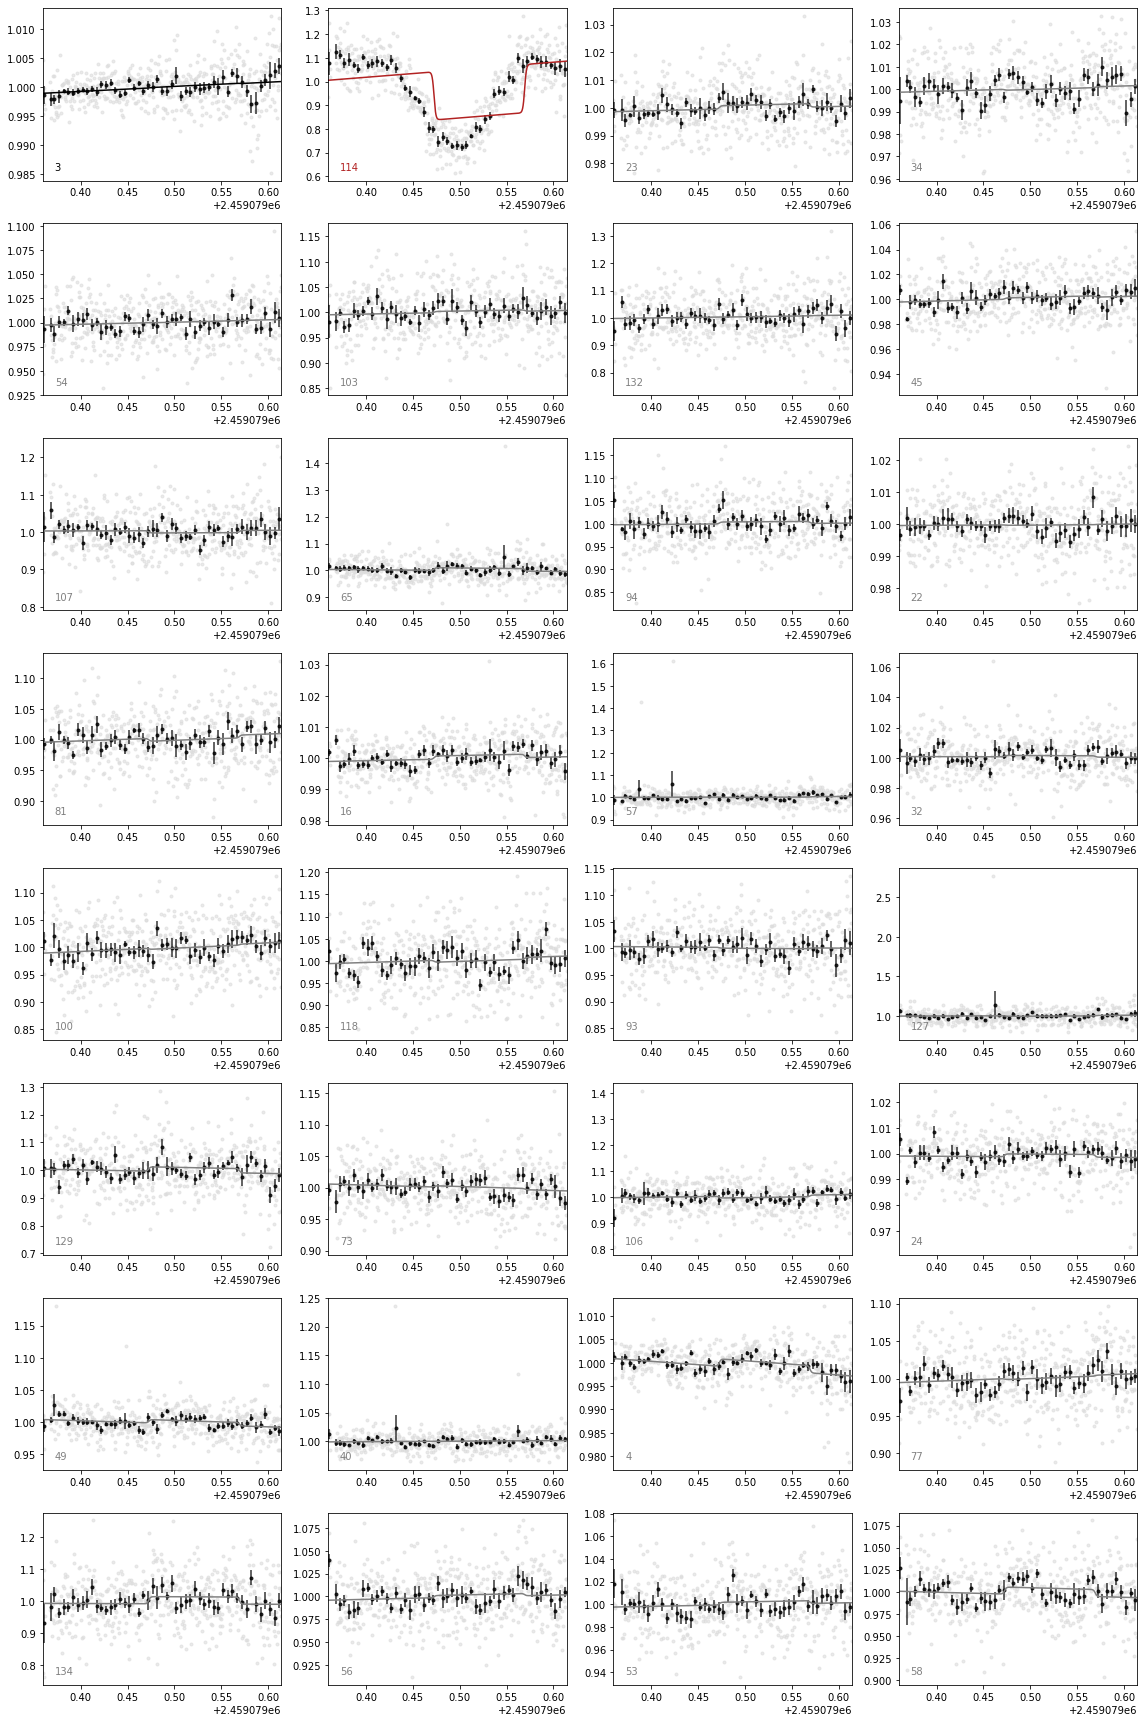

In [9]:
neb.plot()

## Note on catalogs

To perform ``obs.show_tic()`` our stack needed to be solved (i.e. have proper WCS, see [astrometry.net](http://astrometry.net/)). If it is not the case here are conveniant functions to import and export a ``FITS`` image of our observation:


```python
# export the stack image with original headers
obs.export_stack("example.fits")

# import a FITS with appropriate WCS into obs, don't forget to save
obs.import_stack("example_solved.fits")
obs.save() 
```